This notebook includes functions for plotting the figures reported in the paper.

In [36]:
import simsom.config_vals as configs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import glob
import json

# Helpers 

## Read and reformat data

In [49]:
TARGET_PARAMS = [
    "theta",
    "beta",
    "gamma",
    "mu",
    "epsilon",
    "phi",
    "rho",
    "graph_gml",
    "targeting_criterion",
    "quality",
]


def read_data(res_dir, folders, keep_file_name=False):
    """
    Read results of multiple runs into 1 df.
    Result is a .json file containing target_params as specified below.
    'quality' is stored in a list. If there are multiple runs, df contains cols: 'quality_0', 'quality_1', etc.

    Params:
        - folders (list of str): result folders
        - res_dir (str): directory containing result folders
        - keep_file_name (bool): make a file_name column. To distinguish the type of exp if needed
    Outputs:
        - dfs (list of dataframes): each dataframe is the results from a call to driver.py
    """

    dfs = []

    for idx, folder in enumerate(folders):
        try:
            data = []
            for fpath in glob.glob(os.path.join(res_dir, folder, "*.json")):
                exp_res = json.load(open(fpath, "r"))

                # In case error in exp and quality is empty
                if len(exp_res["quality"]) == 0:
                    continue

                row = {}
                for param in TARGET_PARAMS:
                    # if there are multiple qualities, make 'quality' col with a suffix, e.g: quality_00
                    if param == "quality":
                        for jdx, qual in enumerate(exp_res["quality"]):
                            row[f"quality_{jdx}"] = qual
                    else:
                        row[param] = exp_res[param]

                if keep_file_name:
                    row["file_name"] = os.path.basename(fpath)

                data += [row]

            df = pd.DataFrame.from_records(data)
            # print(df)
            df["targeting_criterion"] = df["targeting_criterion"].apply(
                lambda x: "none" if x is None else x
            )
        except Exception as e:
            print(f"Error reading results from folder {folder}")
            print(e)
            continue
        dfs += [df]
        # print(df.head())
    if len(dfs) > 0:
        data = dfs[0]
        for df in dfs[1:]:
            data = pd.merge(
                data, df, on=list(set(TARGET_PARAMS) - set(["quality"])), how="outer"
            )
    else:
        data = pd.DataFrame()
    return data

In [50]:
def get_95_ci(values):
    # return mean-95ci, mean+95ci
    # print(values)
    # values = values[~np.isnan(values)]
    values = list(filter(lambda v: v == v, values))
    print("values", values)
    lower, upper = st.t.interval(
        0.95, len(values) - 1, loc=np.mean(values), scale=st.sem(values)
    )
    ci = (upper - lower) / 2
    return ci


def get_mean(df, col_name_prefix="quality"):
    # df has to have cols with "col_name_prefix" prefix
    # get mean column-wise
    qual_cols = [col for col in df.columns if col_name_prefix in col]
    df[f"mean_{col_name_prefix}"] = df.loc[:, qual_cols].mean(axis=1)
    df[f"std_{col_name_prefix}"] = df.loc[:, qual_cols].std(axis=1)
    df[f"ci_{col_name_prefix}"] = df.apply(
        lambda x: get_95_ci([x[col] for col in qual_cols]), axis=1
    )
    return df


def get_relative(df, baseline, col_name_prefix="quality"):
    """
    Divides the values of the columns matching a prefix by a baseline
    """

    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    for idx, col in enumerate(quality_cols):
        df[f"relative_{col_name_prefix}_{idx}"] = df[col].apply(lambda x: x / baseline)
    return df

In [51]:
## HELPER FOR BOXPLOT


def reindex_cols(df, col_name_prefix="quality"):
    """
    Reset cols with the same prefix, e.g, quality_x_1, quality_y, etc.
    so that they're indexed correctly, e.g, quality_1, quality_2, etc.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with correctly indexed cols
    """

    # de-duplicate columns first. Solution from https://stackoverflow.com/a/24686572
    cols = pd.Series(df.columns)

    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "." + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    df.columns = cols

    # Reindex quality columns
    quality_cols = [col for col in df.columns if col.startswith(col_name_prefix)]
    rename_dict = {
        col: f"{col_name_prefix}_{idx}" for idx, col in enumerate(quality_cols)
    }
    df = df.rename(columns=rename_dict)
    return df


def pivot_results(df, col_name_prefix="quality"):
    """
    Returns long-format df.
    Inputs:
         - df: df with multiple quality columns: "col_name_prefix_x" (resulting from different runs)
    Outputs:
    - df with only 1 quality column: "col_name_prefix_"
    """

    df["id"] = df.index
    df_long = pd.wide_to_long(
        df, [f"{col_name_prefix}_"], i="id", j="run_no"
    ).reset_index()

    return df_long

## Format violin plot

In [40]:
# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax, palette=BLUEPALETTE, n=1, pointsize=200, edgecolor="white", multicolor=True
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(1.5)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

# Setting global variables 

In [22]:
!pwd

/Users/baott/SimSoM/experiments/10122023_alpha_exps


In [41]:
# Directory containing experiment results
RES_DIR = "results"

# Directory to save figures
PLOT_DIR = "figures"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

# Styling
plt.style.use("/Users/baott/SimSoM/experiments/stylesheet.mplstyle")
PALETTE = ["#550F6B", "#F8D625", "#BC3684", "#F18447", "#3863AC", "#209B8A"]
sns.set_palette(PALETTE)

THETA = configs.THETA_SWIPE
PHI = [
    np.round(i, 1) for i in configs.PHI_SWIPE
]  # round to 1 since np range gives many decimals
GAMMA = configs.GAMMA

In [24]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Baseline results

In [42]:
folders = ["baseline", "baseline_7runs"]
dfs = []
for folder in folders:
    data = json.load(open(f"{RES_DIR}/{folder}/baseline.json", "r"))
    df = pd.DataFrame.from_records(data)
    dfs += [df]
data = pd.concat(dfs)
baseline = get_mean(data, col_name_prefix="quality")
baseline_val = baseline["mean_quality"].mean()
print(f"Overall quality when there is no bots: {np.round(baseline_val,2)}")

values [0.46166367974545514]
values [0.4643878129588342]
values [0.4381486467674982]
values [0.4219460000695723]
values [0.41635764335928777]
values [0.4345787224389508]
values [0.4295653148702101]
values [0.45513556459188853]
values [0.4220878639557838]
values [0.4341368425456599]
Overall quality when there is no bots: 0.44


# Shuffle 
Effects of network structure on Quality

In [19]:
# SHUFFLE
data = read_data(RES_DIR, ["shuffle_5runs"], keep_file_name=True)

# refer shuffling strategies from file names
data["shuffle"] = data["file_name"].apply(lambda x: x.split("_shuffle__")[0])
shuffle = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index
shuffle

   theta  beta  gamma   mu  epsilon  phi  rho  \
0      1  0.05   0.01  0.5   0.0001    0  0.8   
1      1  0.05   0.01  0.5   0.0001    0  0.8   
2      1  0.05   0.01  0.5   0.0001    0  0.8   

                                           graph_gml targeting_criterion  \
0  /N/slate/baotruon/simsom_data/data/igraph/shuf...                none   
1  /N/slate/baotruon/simsom_data/data/igraph/shuf...                none   
2  /N/slate/baotruon/simsom_data/data/igraph/shuf...                none   

   quality_0  quality_1  quality_2  quality_3  quality_4  \
0   0.427008   0.405848   0.422218   0.396089   0.382759   
1   0.372875   0.360693   0.365105   0.363559   0.361026   
2   0.383542   0.378106   0.381208   0.369091   0.408733   

                       file_name  
0  community_shuffle__None2.json  
1        hub_shuffle__None2.json  
2        all_shuffle__None2.json  


,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,0.405848,0.422218,0.396089,0.382759,community_shuffle__None2.json,community
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,0.360693,0.365105,0.363559,0.361026,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,0.378106,0.381208,0.369091,0.408733,all_shuffle__None2.json,all


In [20]:
# NO SHUFFLE
data = read_data(RES_DIR, ["vary_thetaphi_5runs"])
data = reindex_cols(data, col_name_prefix="quality").reset_index(
    drop=True
)  # remove duplicated index

noshuffle = data[(data.theta == 1) & (data.phi == 0)]
noshuffle["shuffle"] = "None"

   theta  beta  gamma   mu  epsilon  phi  rho  \
0      1  0.05   0.01  0.5   0.0001  0.0  0.8   
1     64  0.05   0.01  0.5   0.0001  0.7  0.8   
2     32  0.05   0.01  0.5   0.0001  0.0  0.8   
3      4  0.05   0.01  0.5   0.0001  0.4  0.8   
4      1  0.05   0.01  0.5   0.0001  0.8  0.8   

                                           graph_gml targeting_criterion  \
0  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
1  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
2  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
3  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
4  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   

   quality_0  quality_1  quality_2  quality_3  quality_4  
0   0.375325   0.366729   0.377219   0.382236   0.381245  
1   0.360015   0.358583   0.348422   0.324257   0.354738  
2   0.294956   0.355918   0.351713   0.358611   0.379734  
3   0.364429

/var/folders/gj/zfw5qy_n09d78gdzsfht4c7m0000gn/T/ipykernel_1233/842502802.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshuffle["shuffle"] = "None"


In [23]:
noshuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,shuffle
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.375325,0.366729,0.377219,0.382236,0.381245,None


In [24]:
shuffle

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,file_name,shuffle
0,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,0.405848,0.422218,0.396089,0.382759,community_shuffle__None2.json,community
1,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,0.360693,0.365105,0.363559,0.361026,hub_shuffle__None2.json,hub
2,1,0.05,0.01,0.5,0.0001,0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,0.378106,0.381208,0.369091,0.408733,all_shuffle__None2.json,all


In [21]:
data = pd.concat([noshuffle, shuffle]).reset_index(drop=True)
data = get_relative(data, baseline_val, col_name_prefix="quality")
results = pivot_results(data, col_name_prefix="relative_quality")

In [26]:
data

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,...,quality_3,quality_4,shuffle,file_name,relative_quality_0,relative_quality_1,relative_quality_2,relative_quality_3,relative_quality_4,id
0,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.375325,...,0.382236,0.381245,None,NaN,0.958967,0.937005,0.963808,0.976625,0.974094,0
1,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.427008,...,0.396089,0.382759,community,community_shuffle__None2.json,1.091020,1.036956,1.078781,1.012021,0.977962,1
2,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.372875,...,0.363559,0.361026,hub,hub_shuffle__None2.json,0.952707,0.921584,0.932855,0.928906,0.922433,2
3,1,0.05,0.01,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/shuf...,none,0.383542,...,0.369091,0.408733,all,all_shuffle__None2.json,0.979962,0.966074,0.973999,0.943040,1.044326,3


In [27]:
results

,id,run_no,epsilon,graph_gml,phi,beta,rho,shuffle,quality_1,targeting_criterion,gamma,theta,quality_4,quality_0,quality_2,mu,quality_3,file_name,relative_quality_
0,0,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,None,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.958967
1,1,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,community,0.405848,none,0.01,1,0.382759,0.427008,0.422218,0.5,0.396089,community_shuffle__None2.json,1.091020
2,2,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,hub,0.360693,none,0.01,1,0.361026,0.372875,0.365105,0.5,0.363559,hub_shuffle__None2.json,0.952707
3,3,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,all,0.378106,none,0.01,1,0.408733,0.383542,0.381208,0.5,0.369091,all_shuffle__None2.json,0.979962
4,0,1,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,None,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.937005
5,1,1,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,community,0.405848,none,0.01,1,0.382759,0.427008,0.422218,0.5,0.396089,community_shuffle__None2.json,1.036956
6,2,1,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,hub,0.360693,none,0.01,1,0.361026,0.372875,0.365105,0.5,0.363559,hub_shuffle__None2.json,0.921584
7,3,1,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,all,0.378106,none,0.01,1,0.408733,0.383542,0.381208,0.5,0.369091,all_shuffle__None2.json,0.966074
8,0,2,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,None,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.963808
9,1,2,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,community,0.405848,none,0.01,1,0.382759,0.427008,0.422218,0.5,0.396089,community_shuffle__None2.json,1.078781


Plot data for default values $\gamma=0.01$

In [28]:
plot_data = results[(results.gamma == 0.01) & (results.targeting_criterion == "none")]
plot_data.head()

,id,run_no,epsilon,graph_gml,phi,beta,rho,shuffle,quality_1,targeting_criterion,gamma,theta,quality_4,quality_0,quality_2,mu,quality_3,file_name,relative_quality_
0,0,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,None,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.958967
1,1,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,community,0.405848,none,0.01,1,0.382759,0.427008,0.422218,0.5,0.396089,community_shuffle__None2.json,1.091020
2,2,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,hub,0.360693,none,0.01,1,0.361026,0.372875,0.365105,0.5,0.363559,hub_shuffle__None2.json,0.952707
3,3,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,all,0.378106,none,0.01,1,0.408733,0.383542,0.381208,0.5,0.369091,all_shuffle__None2.json,0.979962
4,0,1,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,None,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.937005


In [16]:
# !pip install statannotations

In [17]:
plot_data

,id,run_no,epsilon,graph_gml,phi,beta,rho,shuffle,quality_1,targeting_criterion,gamma,theta,quality_4,quality_0,quality_2,mu,quality_3,file_name,relative_quality_
0,0,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,hubs+communities,0.366729,none,0.01,1,0.381245,0.375325,0.377219,0.5,0.382236,NaN,0.958967
1,1,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.7,0.05,0.8,hubs+communities,0.358583,none,0.01,64,0.354738,0.360015,0.348422,0.5,0.324257,NaN,0.919851
2,2,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.0,0.05,0.8,hubs+communities,0.355918,none,0.01,32,0.379734,0.294956,0.351713,0.5,0.358611,NaN,0.753622
3,3,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.4,0.05,0.8,hubs+communities,0.364873,none,0.01,4,0.366044,0.364429,0.359110,0.5,0.368996,NaN,0.931129
4,4,0,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.8,0.05,0.8,hubs+communities,0.324562,none,0.01,1,0.329496,0.328910,0.322417,0.5,0.331181,NaN,0.840376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,13,4,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.9,0.05,0.8,hubs+communities,0.372509,none,0.01,2,0.358656,0.331620,0.362411,0.5,0.371941,NaN,0.916379
86,14,4,0.0001,/N/slate/baotruon/simsom_data/data/igraph/vary...,0.5,0.05,0.8,hubs+communities,0.357699,none,0.01,8,0.326937,0.370110,0.354427,0.5,0.360157,NaN,0.835336
87,15,4,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,communities,0.405848,none,0.01,1,0.382759,0.427008,0.422218,0.5,0.396089,community_shuffle__None2.json,0.977962
88,16,4,0.0001,/N/slate/baotruon/simsom_data/data/igraph/shuf...,0.0,0.05,0.8,hubs,0.360693,none,0.01,1,0.361026,0.372875,0.365105,0.5,0.363559,hub_shuffle__None2.json,0.922433


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

communities vs. hubs+communities: Welch's t-test independent samples, P_val:1.787e-02 t=3.500e+00
hubs vs. communities: Welch's t-test independent samples, P_val:5.345e-03 t=-4.970e+00
random vs. hubs: Welch's t-test independent samples, P_val:3.941e-02 t=2.791e+00
random vs. hubs+communities: Welch's t-test independent samples, P_val:3.357e-01 t=1.057e+00


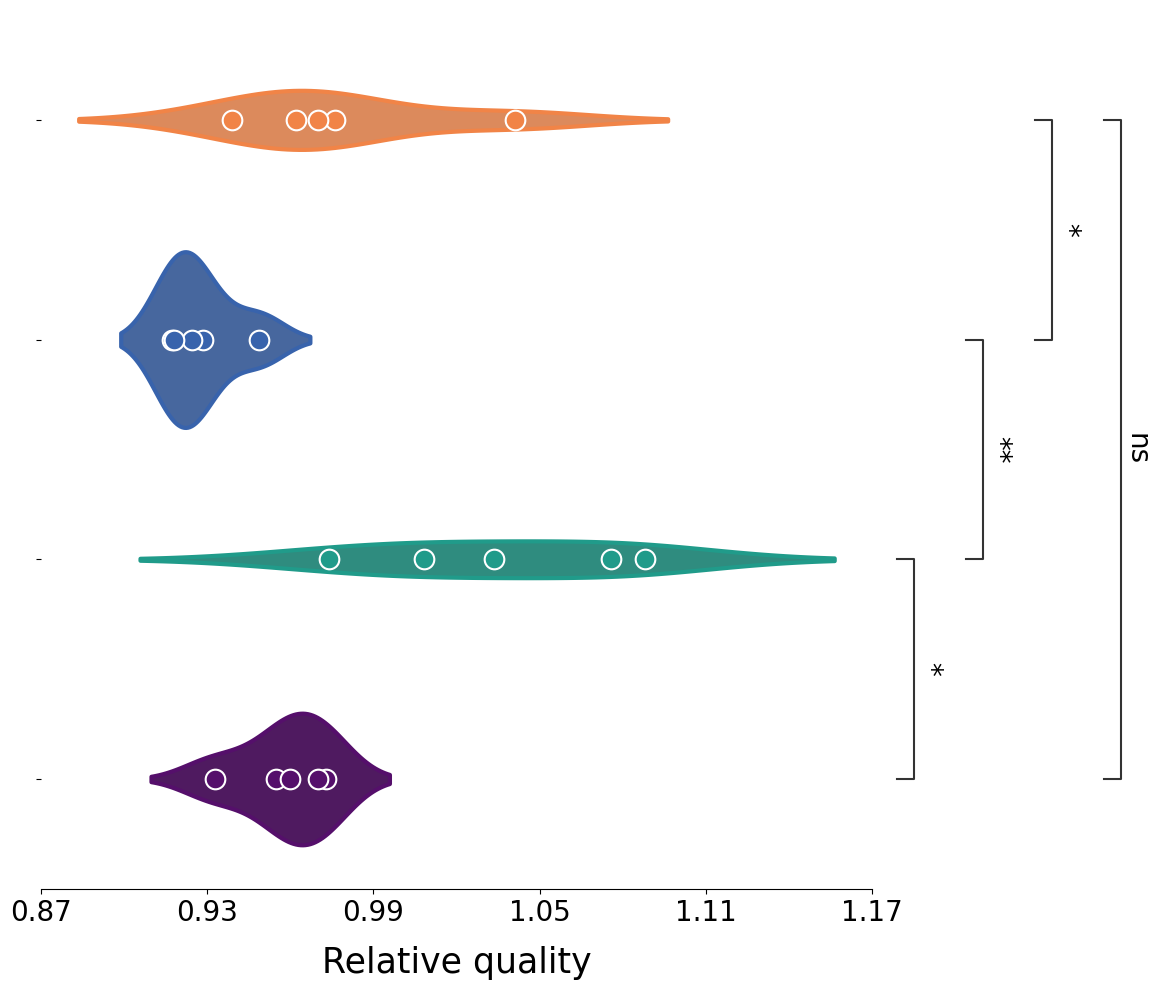

In [29]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "shuffle")
fig, ax = plt.subplots(figsize=(12, 10))
ax.xaxis.set_major_locator(plt.LinearLocator(6))
ax.xaxis.set_major_formatter("{x:.02f}")
order = ["random", "hubs", "communities", "hubs+communities"]

# Rename shuffles
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "random" if x == "all" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "hubs+communities" if x == "None" else x
)
plot_data["shuffle"] = plot_data["shuffle"].apply(lambda x: "hubs" if x == "hub" else x)
plot_data["shuffle"] = plot_data["shuffle"].apply(
    lambda x: "communities" if x == "community" else x
)

violin = sns.violinplot(
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    order=order,
    #                         scale='width',
    inner="point",
    palette=BLUEPALETTE,
)

pairs = [
    ("hubs+communities", "communities"),
    ("hubs+communities", "random"),
    ("hubs", "communities"),
    ("hubs", "random"),
]
annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    y="shuffle",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    # comparisons_correction="bonferroni"
    comparisons_correction=None,
)
annotator.apply_and_annotate()

violin.set(yticklabels=[])
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)
violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=25, labelpad=14)
patch_violinplot(ax, palette=BLUEPALETTE, n=4)
point_violinplot(ax, palette=BLUEPALETTE, n=4)
sns.despine(top=True, left=True, bottom=False)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Alpha

In [43]:
folders = ["vary_alpha"]
TARGET_PARAMS.append("alpha")

data = read_data(RES_DIR, folders)
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
alphadata = pivot_results(data, col_name_prefix="quality")
alphadata = alphadata.sort_values(by="alpha")
alphadata.head()

Error reading results from folder vary_alpha
'targeting_criterion'


In [44]:
data

""


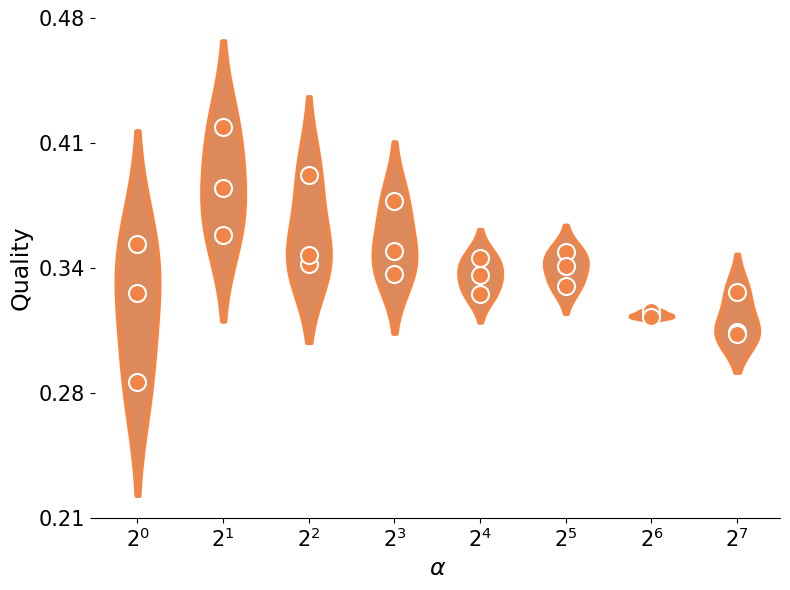

In [34]:
fpath = os.path.join(PLOT_DIR, "alpha")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=alphadata,
    x="alpha",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)

# Formatting
ticks = range(len(alphadata.alpha.unique()))
violin.set_xticks(ticks)
violin.set_xticklabels([f"$2^{i}$" for i in ticks])

violin.set_xlabel(f"$\\alpha$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)

sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Mu

In [30]:
RES_DIR

'results'

In [55]:
# Read data
data = read_data(RES_DIR, ["vary_mu"])
data = reindex_cols(data, col_name_prefix="quality")

mudata = pivot_results(data, col_name_prefix="quality")

mudata = mudata.sort_values(by="mu")
mudata.head()

,id,run_no,theta,graph_gml,mu,gamma,epsilon,phi,rho,beta,targeting_criterion,quality_
43,3,8,1,/Users/baott/SimSoM/experiments/10122023_alpha...,0.1,0.01,0.0001,0,0.8,0.05,none,0.514245
3,3,0,1,/Users/baott/SimSoM/experiments/10122023_alpha...,0.1,0.01,0.0001,0,0.8,0.05,none,0.522557
38,3,7,1,/Users/baott/SimSoM/experiments/10122023_alpha...,0.1,0.01,0.0001,0,0.8,0.05,none,0.455062
33,3,6,1,/Users/baott/SimSoM/experiments/10122023_alpha...,0.1,0.01,0.0001,0,0.8,0.05,none,0.492382
8,3,1,1,/Users/baott/SimSoM/experiments/10122023_alpha...,0.1,0.01,0.0001,0,0.8,0.05,none,0.544089


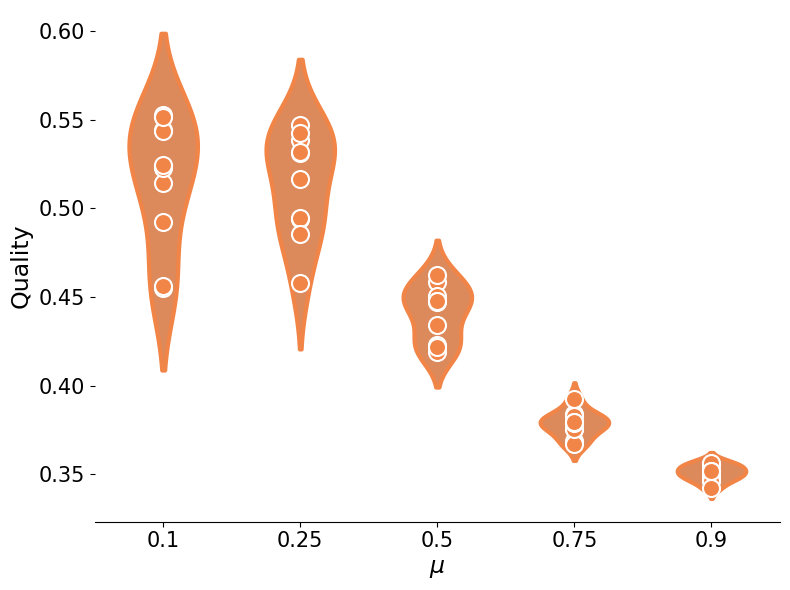

In [56]:
fpath = os.path.join(PLOT_DIR, "mu")
color = "#F18447"  # orange

fig, ax = plt.subplots(figsize=(8, 6))
ax.yaxis.set_major_locator(plt.MaxNLocator(7))
ax.yaxis.set_major_formatter("{x:.02f}")
violin = sns.violinplot(
    data=mudata,
    x="mu",
    y="quality_",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Formatting
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

violin.set_xlabel(f"$\\mu$")
violin.set_ylabel("Quality")

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()

# Bot params

## Read data 
Data is a subset of joint effect experiments

### Thetaphi

In [32]:
RES_DIR_ = "results_bigred"
data = read_data(
    RES_DIR_, folders=["vary_thetaphi", "vary_thetaphi_4runs", "vary_thetaphi_5runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")
# Remove duplicate col names and index
thetaphi = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

   theta  beta  gamma   mu  epsilon  phi  rho  \
0      2  0.05   0.01  0.5   0.0001  0.7  0.8   
1      8  0.05   0.01  0.5   0.0001  0.7  0.8   
2      1  0.05   0.01  0.5   0.0001  1.0  0.8   
3      2  0.05   0.01  0.5   0.0001  0.0  0.8   
4     32  0.05   0.01  0.5   0.0001  0.1  0.8   

                                           graph_gml targeting_criterion  \
0  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
1  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
2  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
3  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
4  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   

   quality_0  
0   0.312667  
1   0.255999  
2   0.298287  
3   0.334539  
4   0.315435  
   theta  beta  gamma   mu  epsilon  phi  rho  \
0      4  0.05   0.01  0.5   0.0001  0.5  0.8   
1      1  0.05   0.01  0.5   0.0001  0.5  0.8   
2      8  0

### Phigamma

In [33]:
data = read_data(
    RES_DIR, folders=["vary_phigamma", "vary_phigamma_5runs", "vary_phigamma_4runs"]
)
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
phigamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

   theta  beta   gamma   mu  epsilon  phi  rho  \
0      1  0.05  0.0001  0.5   0.0001  0.2  0.8   
1      1  0.05  0.0001  0.5   0.0001  0.0  0.8   
2      1  0.05  0.0100  0.5   0.0001  0.0  0.8   
3      1  0.05  0.0001  0.5   0.0001  1.0  0.8   

                                           graph_gml targeting_criterion  \
0  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
1  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
2  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
3  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   

   quality_0  quality_1  quality_2  
0   0.407664   0.410463   0.394350  
1   0.414997   0.409541   0.402852  
2   0.311604   0.313477   0.310620  
3   0.408485   0.413042   0.409034  
Error reading results from folder vary_phigamma_5runs
'targeting_criterion'
   theta  beta   gamma   mu  epsilon  phi  rho  \
0      1  0.05  0.0001  0.5   0.0001  0.0  0.8   
1      

### Thetagamma

In [34]:
data = read_data(RES_DIR, folders=["vary_thetagamma", "vary_thetagamma_4runs"])
# Reset quality cols
data = reindex_cols(data, col_name_prefix="quality")

# Remove duplicate col names and index
thetagamma = data.loc[:, ~data.columns.duplicated()].copy().reset_index(drop=True)

   theta  beta   gamma   mu  epsilon  phi  rho  \
0      1  0.05  0.0001  0.5   0.0001    0  0.8   
1     64  0.05  0.0001  0.5   0.0001    0  0.8   
2      8  0.05  0.0010  0.5   0.0001    0  0.8   
3      2  0.05  0.0010  0.5   0.0001    0  0.8   
4      4  0.05  0.1000  0.5   0.0001    0  0.8   

                                           graph_gml targeting_criterion  \
0  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
1  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
2  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
3  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   
4  /N/slate/baotruon/simsom_data/data/igraph/vary...                none   

   quality_0  quality_1  quality_2  
0   0.398602   0.416049   0.402657  
1   0.405372   0.403216   0.413620  
2   0.384742   0.390206   0.396495  
3   0.396136   0.385382   0.402647  
4   0.302730   0.347347   0.290326  
   theta  beta  gamm

## Single param plots
Subset data (only plot default values for each panel)

In [36]:
phigamma

,theta,beta,gamma,mu,epsilon,phi,rho,graph_gml,targeting_criterion,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6
0,1,0.05,0.0001,0.5,0.0001,0.2,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.407664,0.410463,0.394350,NaN,NaN,NaN,NaN
1,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.414997,0.409541,0.402852,0.403093,0.408421,0.409933,0.416336
2,1,0.05,0.0100,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.311604,0.313477,0.310620,NaN,NaN,NaN,NaN
3,1,0.05,0.0001,0.5,0.0001,1.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.408485,0.413042,0.409034,0.412648,0.406402,0.415886,0.405931


In [37]:
vary_gamma

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,relative_quality_7,relative_quality_8,relative_quality_9,relative_quality_10,relative_quality_11,relative_quality_12,relative_quality_13,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.414997,...,0.983469,1.026517,0.993474,NaN,NaN,NaN,NaN,1.007269,0.015526,NaN


In [56]:
vary_phi = pd.merge(
    thetaphi[thetaphi.theta == 1],
    phigamma[phigamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_phi

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,rho_y,graph_gml_y,targeting_criterion_y,quality_0_y,quality_1_y,quality_2_y,quality_3_y,quality_4_y,quality_5,quality_6


In [57]:
# VARYING GAMMA
vary_gamma = pd.merge(
    phigamma[phigamma.phi == 0],
    thetagamma[thetagamma.theta == 1],
    on=["theta", "beta", "gamma", "phi"],
)
vary_gamma = get_relative(vary_gamma, baseline_val, col_name_prefix="quality")
vary_gamma = get_mean(vary_gamma, col_name_prefix="relative_quality")
x = vary_gamma["gamma"]
y = vary_gamma["mean_relative_quality"]
# err = vary_gamma["ci_relative_quality"]
err = vary_gamma["std_relative_quality"]
gammadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING PHI
# vary_phi = pd.merge(
#     thetaphi[thetaphi.theta == 1],
#     phigamma[phigamma.gamma == 0.01],
#     on=["theta", "beta", "gamma", "phi"],
# )
# vary_phi = get_relative(vary_phi, baseline_val, col_name_prefix="quality")
# vary_phi = get_mean(vary_phi, col_name_prefix="relative_quality")
# x = [0.1 * i for i in vary_phi["phi"]]
# y = vary_phi["mean_relative_quality"]
# err = vary_phi["ci_relative_quality"]
# err = vary_phi["std_relative_quality"]
# phidata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

# VARYING THETA
vary_theta = pd.merge(
    thetaphi[thetaphi.phi == 0],
    thetagamma[thetagamma.gamma == 0.01],
    on=["theta", "beta", "gamma", "phi"],
)
vary_theta = get_relative(vary_theta, baseline_val, col_name_prefix="quality")
vary_theta = get_mean(vary_theta, col_name_prefix="relative_quality")
x = vary_theta["theta"]
y = vary_theta["mean_relative_quality"]
err = vary_theta["ci_relative_quality"]
# err = vary_theta["std_relative_quality"]
thetadata = zip(*sorted(zip(x, y, err), key=lambda x: x[0]))

values [1.023921407737816, 1.010458377764823, 0.9939552935506971, 0.9945498083663153, 1.007696555406698, 1.0114267829767967, 1.0272252358928848, 0.9834692821346546, 1.0265171601272143, 0.99347381768492]


ValueError: Expected a 1D array, got an array with shape (0, 40)

In [61]:
vary_gamma

,theta,beta,gamma,mu_x,epsilon_x,phi,rho_x,graph_gml_x,targeting_criterion_x,quality_0_x,...,relative_quality_7,relative_quality_8,relative_quality_9,relative_quality_10,relative_quality_11,relative_quality_12,relative_quality_13,mean_relative_quality,std_relative_quality,ci_relative_quality
0,1,0.05,0.0001,0.5,0.0001,0.0,0.8,/N/slate/baotruon/simsom_data/data/igraph/vary...,none,0.414997,...,0.983469,1.026517,0.993474,NaN,NaN,NaN,NaN,1.007269,0.015526,0.011106


### Plot

In [60]:
gammadata

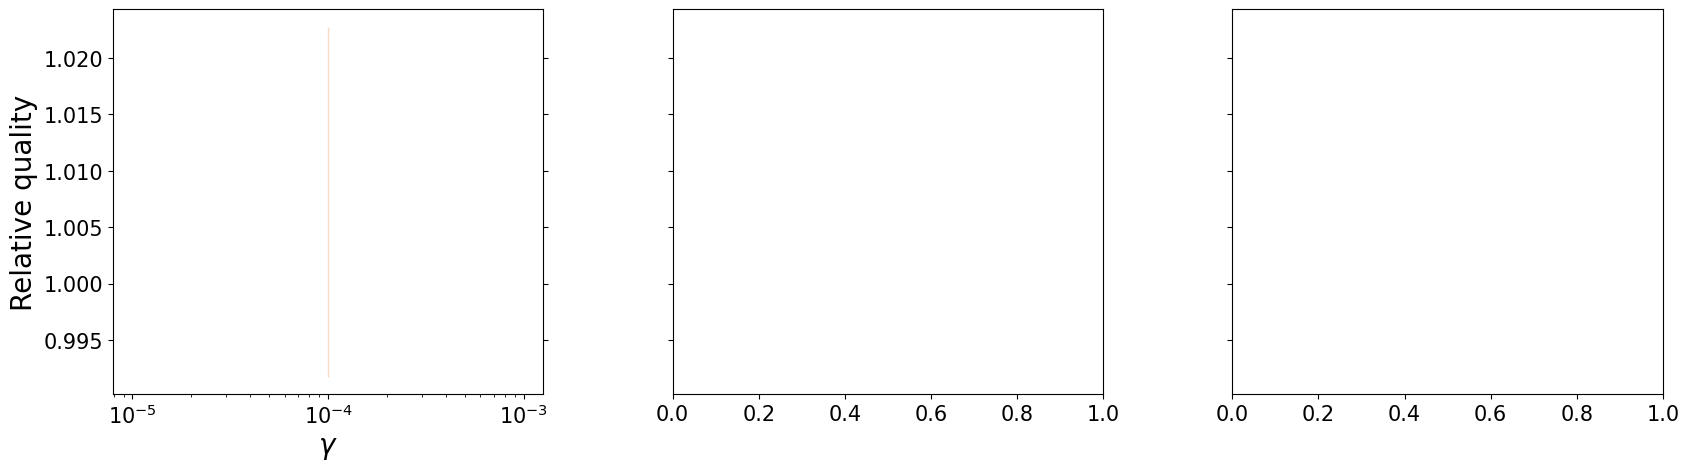

In [59]:
fpath = os.path.join(PLOT_DIR, "botparam")
color = "#F18447"  # orange

y_axis = "Relative quality"
fig, axs = plt.subplots(
    1, 3, figsize=(20, 5), sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use("stylesheet.mplstyle")


## Helper
def draw_lines(ax, data, line_name="hub", marker="", linewidth=4, color="#F18447"):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_err = data
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        np.subtract(np.array(y), np.array(y_err)),
        np.add(np.array(y), np.array(y_err)),
        color=color,
        alpha=0.3,
    )
    return


# GAMMA
ax = axs[0]
draw_lines(ax, gammadata, color=color)
ax.set_xlabel("$\\gamma$", fontsize=20)
ax.set_ylabel(y_axis, fontsize=20, labelpad=4)
ax.set_xscale("log")
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)


# # THETA
# ax = axs[1]
# draw_lines(ax, thetadata, color=color)
# ax.set_xlabel("$\\theta$", fontsize=20, labelpad=4)
# ax.set_xscale("log", base=2)
# ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
# ax.xaxis.set_major_locator(
#     plt.LogLocator(base=2, numticks=len(vary_theta["theta"]) + 1)
# )
# # ax.xaxis.set_major_locator(plt.MultipleLocator())

# # PHI
# ax = axs[2]
# draw_lines(ax, phidata, color=color)
# ax.set_xlabel("$\\phi$", fontsize=20, labelpad=4)
# ax.tick_params(labelleft=True, labelright=False, left=True, right=True)

# Increase space between subplots to look nice with contour plot in a panel instead of tight_layout()
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None
)

if fpath is not None:
    plt.savefig(f"{fpath}.pdf")
    plt.savefig(f"{fpath}.png")
else:
    plt.show()

## Contour plots
First we need to convert data to the right input shape for matplotlib plot_surface()

### Data: Thetaphi matrix

In [195]:
thetaphi = get_relative(thetaphi, baseline_val, col_name_prefix="quality")
thetaphi = get_mean(thetaphi, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetaphi = thetaphi.drop_duplicates(subset=["theta", "phi"], keep="first")
thetaphi = thetaphi.pivot(
    index="theta", columns="phi", values="mean_relative_quality"
).reset_index()
# Pandas convert phi into np.float (e.g, 0.3000000000 instead of 0.3) so we need to change column names to match with PHI
thetaphi.columns = ["theta"] + PHI
thetaphi.head()

,theta,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0,1,0.823089,0.747759,0.729006,0.711123,0.699886,0.707850,0.690290,0.671740,0.649171,0.673285,0.666195
1,2,0.733259,0.676325,0.648990,0.634831,0.608693,0.626885,0.600837,0.596249,0.605134,0.563884,0.578726
2,4,0.671234,0.584056,0.565105,0.532507,0.539577,0.534363,0.511447,0.528932,0.514204,0.516872,0.505527
3,8,0.560878,0.531023,0.482729,0.493488,0.479664,0.464420,0.433366,0.445564,0.434946,0.435710,0.432124
4,16,0.527473,0.467691,0.456769,0.426737,0.417820,0.412263,0.401047,0.387606,0.394171,0.384138,0.383878


In [150]:
tp_matrix = thetaphi.loc[:, PHI].values
# Check shape:
tp_matrix.shape

(6, 11)

### Data: Thetagamma matrix

In [163]:
thetagamma = get_relative(thetagamma, baseline_val, col_name_prefix="quality")
thetagamma = get_mean(thetagamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
thetagamma = thetagamma.drop_duplicates(subset=["theta", "gamma"], keep="first")
thetagamma = thetagamma.pivot(
    index="theta", columns="gamma", values="mean_relative_quality"
).reset_index()
thetagamma.head()

gamma,theta,0.0001,0.001,0.01,0.1
0,1,0.994242,0.976019,0.835927,0.432603
1,2,0.995101,0.959099,0.750875,0.309886
2,4,0.994702,0.926577,0.676021,0.215199
3,8,0.990502,0.907169,0.579756,0.152144
4,16,0.983979,0.896671,0.526216,0.105486


In [164]:
tg_matrix = thetagamma.loc[:, GAMMA].values
tg_matrix.shape

(6, 4)

### Data: Phigamma matrix

In [167]:
phigamma = get_relative(phigamma, baseline_val, col_name_prefix="quality")
phigamma = get_mean(phigamma, col_name_prefix="relative_quality")

# drop duplicate & reshape
phigamma = phigamma.drop_duplicates(subset=["phi", "gamma"], keep="first")
phigamma = phigamma.pivot(
    index="phi", columns="gamma", values="mean_relative_quality"
).reset_index()
phigamma.head()

gamma,phi,0.0001,0.001,0.01,0.1
0,0.0,0.994159,0.969971,0.830530,0.433707
1,0.1,0.983699,0.956408,0.766769,0.379524
2,0.2,0.985328,0.914810,0.722784,0.382089
3,0.3,0.985161,0.914188,0.709021,0.376902
4,0.4,0.984142,0.917724,0.695761,0.361630


In [168]:
pg_matrix = phigamma.loc[:, GAMMA].values
pg_matrix.shape

(11, 4)

### Plot

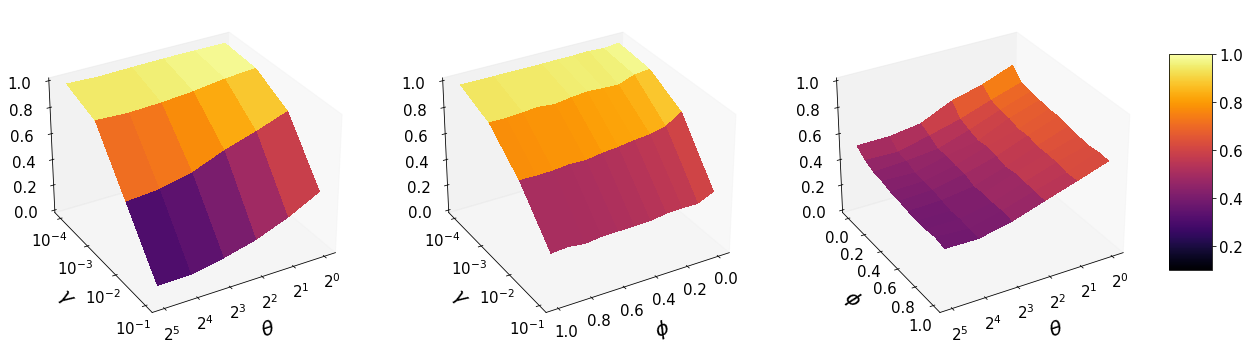

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Matplotlib plot surface doesn't support plotting log scale yet
# calling ax.zaxis._set_scale('log') only labels the axis in logarithm scale but not actually plotting in logarithm scale
# Solution 1: convert to log scale (line 36) then use a custom formatter function (line 14)
# from https://stackoverflow.com/a/67774238


def log_tick_formatter(val, pos=None, base=2):
    return f"${base}^{{{val:g}}}$"


fpath = os.path.join(PLOT_DIR, "joint")
cmap = plt.get_cmap("inferno")
fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(20, 6))

# Get range for plotting shared color bar
min_qual = min(min(tp_matrix.ravel()), min(tg_matrix.ravel()), min(pg_matrix.ravel()))
max_qual = max(max(tp_matrix.ravel()), max(tg_matrix.ravel()), max(pg_matrix.ravel()))
VMIN = np.round(min_qual, 2)
VMAX = np.round(max_qual, 2)

# For these exps we only plot a short range of theta
THETA_SHORT = [1, 2, 4, 8, 16, 32, 64]

## THETAGAMMA
X = THETA_SHORT
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = tg_matrix.T

# PLOT SURFACE
ax = axs[0]
surf = ax.plot_surface(
    np.log2(X),
    np.log10(Y),
    Z,
    cmap=cmap,
    linewidth=0,
    antialiased=False,
    vmin=VMIN,
    vmax=VMAX,
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks
ax.set_ylabel(f"$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)


## PHIGAMMA
ax = axs[1]

X = PHI
Y = configs.GAMMA
X, Y = np.meshgrid(X, Y)
Z = pg_matrix.T

# PLOT
surf = ax.plot_surface(
    X, np.log10(Y), Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
ax.xaxis.set_major_formatter("{x:.01f}")

ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, pos: log_tick_formatter(val, base=10))
)
ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.locator_params(axis="y", nbins=len(GAMMA))  # Set num ticks, 'y', 'x' or 'both'
ax.set_ylabel("$\\gamma$", fontsize=20, labelpad=13)
ax.set_xlabel("$\\phi$", fontsize=20, labelpad=13)

# Add a color bar which maps values to colors.
cbar_ax = fig.add_axes([0.92, 0.27, 0.03, 0.5])  # x,y,width, height
fig.colorbar(surf, shrink=0.7, aspect=10, cax=cbar_ax)


## THETAPHI
X = THETA_SHORT
Y = PHI
X, Y = np.meshgrid(X, Y)
Z = tp_matrix.T

# PLOT SURFACE
ax = axs[2]
surf = ax.plot_surface(
    np.log2(X), Y, Z, cmap=cmap, linewidth=0, antialiased=False, vmin=VMIN, vmax=VMAX
)

# FORMATTING
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))
ax.yaxis.set_major_formatter("{x:.01f}")
# ax.set_zlabel(f"Relative Quality", fontsize=20, labelpad=20, rotation=90)
ax.set_xlabel(f"$\\theta$", fontsize=20, labelpad=13)
ax.set_ylabel(f"$\\phi$", fontsize=20, labelpad=13)


# rotate the axes and update
for ax in axs:
    ax.tick_params(axis="z", which="major", pad=10)
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    ax.zaxis.set_major_formatter("{x:.01f}")
    ax.grid(False)
    ax.view_init(30, 60)

plt.draw()
# Saving
if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Bot targeting

Differences in overall quality are insignificant for $\gamma=0.01$. Were plotting different bot targeting strategies for $\gamma=0.1$

In [48]:
dfs = read_data(RES_DIR, folders=["vary_gamma"])
data = dfs[0]
data = data[data.gamma == 0.1]
data = reindex_cols(data, col_name_prefix="quality")
data = get_relative(data, baseline_val, col_name_prefix="quality")
targetdata = pivot_results(data, col_name_prefix="relative_quality")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

random vs. hubs: Welch's t-test independent samples, P_val:2.053e-04 t=-4.981e+00
random vs. misinformation: Welch's t-test independent samples, P_val:7.296e-06 t=-6.759e+00
random vs. liberal: Welch's t-test independent samples, P_val:8.538e-13 t=-3.215e+01
random vs. conservative: Welch's t-test independent samples, P_val:8.094e-14 t=-3.245e+01


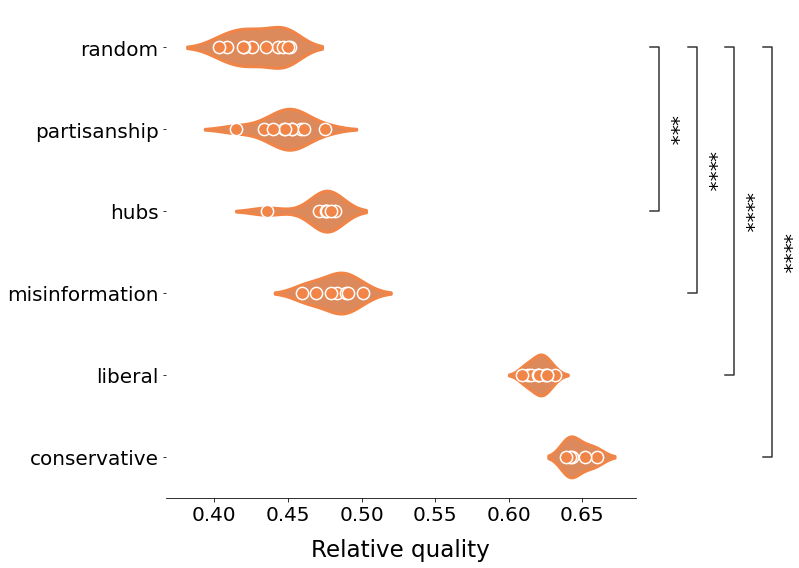

In [172]:
from statannotations.Annotator import Annotator

fpath = os.path.join(PLOT_DIR, "targeting")
color = "#F18447"  # orange

# change name of no targeting scenario
targetdata["targeting_criterion"] = targetdata["targeting_criterion"].apply(
    lambda x: "random" if x == "none" else x
)

order = ["random", "partisanship", "hubs", "misinformation", "liberal", "conservative"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.yaxis.set_major_locator(plt.LinearLocator(5))
violin = sns.violinplot(
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    order=order,
    orient="h",
    ax=ax,
    scale="width",
    width=0.5,
    inner="point",
    color=color,
)
# Add statistical significance
pairs = [
    ("misinformation", "random"),
    ("liberal", "random"),
    ("hubs", "random"),
    ("conservative", "random"),
    #         ('partisanship', 'random') #insignificant
]
annotator = Annotator(
    ax,
    pairs,
    data=targetdata,
    y="targeting_criterion",
    x="relative_quality_",
    orient="h",
    order=order,
)
annotator.configure(
    test="t-test_welch",
    text_format="star",
    loc="outside",
    fontsize=20,
    comparisons_correction=None,
)
annotator.apply_and_annotate()

# Format
violin.tick_params(axis="x", labelsize=20)
violin.tick_params(axis="y", labelsize=20)

violin.set_ylabel(None)
violin.set_xlabel("Relative quality", fontsize=23, labelpad=14)

patch_violinplot(ax, alpha=1, multicolor=False)
point_violinplot(ax, pointsize=150, edgecolor="white", multicolor=False)
sns.despine(top=True, right=True, left=True)

# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf")
    fig.savefig(f"{fpath}.png")
else:
    plt.show()